In [154]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("/usr/local/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [178]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("../data/sim_sleep2")
prefix = "rf4"

number_neurons = 4096
number_stimuli = 6
time_range = 2400
bin_size = 100e-3

In [179]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtimes = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),number_stimuli))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtimes[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=number_neurons)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...


### Get cell assemblies

In [180]:
# Constants
t_activity_start = 3
t_activity_end = 3.5
response_start = int(t_activity_start / bin_size)
response_end = int(t_activity_end / bin_size)
spike_threshold = 20 * (response_end - response_start) * bin_size  # Hz

stim_start_times = stimtimes[1::4]
stims = np.array([np.where(stim)[0][0] for stim in stimdata[1::4]]) 

# Ignore the stimuli when a different stimulus occured right after
to_remove = []
for i in range(len(stim_start_times) - 1):
  if stim_start_times[i] + t_activity_end >= stim_start_times[i+1]:
    if(stims[i] != stims[i+1]):
      to_remove.append(i)
stim_start_times = np.delete(stim_start_times, to_remove)
stims = np.delete(stims, to_remove)

# Function to get the associated time bin for the given float time. Ex: for t = 0.5, returns 50
def get_time_bin(t):
    return int(t / bin_size)

# Identify relevant time bins for each stimulus
response_bins = [
    np.array(range(
        get_time_bin(t) + response_start,
        min(get_time_bin(t) + response_end, get_time_bin(time_range)-1)
    ), dtype=int)
    for t in stim_start_times
]

stimulus_time_bins_list = [[] for _ in range(number_stimuli)]
for stim, bins in zip(stims, response_bins):
    stimulus_time_bins_list[stim].extend(bins)

# Determine which neurons respond to each stimulus
responding_neurons = []

for bins in stimulus_time_bins_list:
    # Sum up the spikes for each neuron in the identified bins
    spike_counts = np.sum(data[bins], axis=0)
    frequency = spike_counts / (len(bins) * bin_size)
    
    responding = np.where(frequency > spike_threshold)[0]
    responding_neurons.append(responding)

for i, neurons in enumerate(responding_neurons):
    print(f"Stimulus {i} has {len(neurons)} responding neurons")

Stimulus 0 has 42 responding neurons
Stimulus 1 has 34 responding neurons
Stimulus 2 has 829 responding neurons
Stimulus 3 has 731 responding neurons
Stimulus 4 has 308 responding neurons
Stimulus 5 has 652 responding neurons


### Network activation for each stimulus

Plotting ...
[array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0]), array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])]


/tmp/ipykernel_4424/2686328616.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = plt.stem(selected_times, spikes_stim[stim], basefmt=" ", linefmt=f'C{stim}', markerfmt=" ", use_line_collection=True)


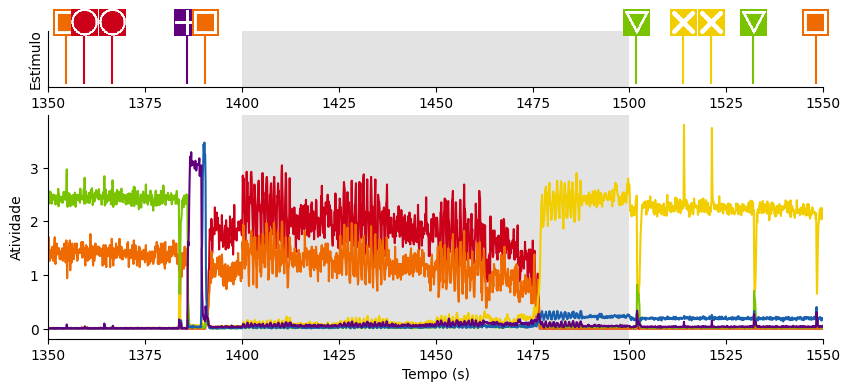

In [182]:
t_begin = 1350
t_end = 1550
# t_begin = 0
# t_end = 2400
# t_begin = 150
# t_end = 350

# t_begin = 450
# t_end = 650
t_begin_bin = int(t_begin // bin_size)
t_end_bin = int(t_end // bin_size)

time_mask = (stim_start_times > t_begin) & (stim_start_times < t_end)
selected_times = stim_start_times[time_mask]

single_stim_data = []
spikes_stim = []
ys = []
for stim in range(number_stimuli):
  curr_single_stim_data = data[:,responding_neurons[stim]][t_begin_bin:t_end_bin]
  curr_spikes_stim = np.where(stims == stim, 1, 0)[time_mask]
  curr_y = np.mean(curr_single_stim_data, axis=1)

  single_stim_data.append(curr_single_stim_data)
  spikes_stim.append(curr_spikes_stim)
  ys.append(curr_y) 

imgs = ['circle.png', 'square.png', 'x.png', 'triangle.png', 'diamond.png', 'plus.png']
colors = ['#cd001a', '#ef6a00', '#f2cd00', '#79c300', '#1961ae', '#61007d']

print("Plotting ...")
time = np.linspace(t_begin, t_end, len(ys[0]))
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(10,4))
cmap = plt.get_cmap('Set1', number_stimuli)

ax = plt.subplot(gs[0])
ax.set_yticks([])
# plt.plot(stimtimes, stimdata, color="gray")
for stim in range(number_stimuli):
  markerline, stemlines, baseline = plt.stem(selected_times, spikes_stim[stim], basefmt=" ", linefmt=f'C{stim}', markerfmt=" ", use_line_collection=True)
  plt.setp(stemlines, 'color', colors[stim])
print(spikes_stim)
for i,t in enumerate(selected_times):
    s = next((x for x,arr in enumerate(spikes_stim) if arr[i] == 1), None)
    img = plt.imread(f"./stimuli/{imgs[s]}")
    imagebox = OffsetImage(img, zoom=0.3)  
    ab = AnnotationBbox(imagebox, (t, 0), frameon=False, boxcoords="data", pad=0, box_alignment=(0.5, -1.8))
    ax.add_artist(ab)

for i in range(0, time_range, 300):
  ax.axvspan(i + 200, i + 300, facecolor='#e3e3e3', edgecolor='none')

plt.xlim((t_begin,t_end))
plt.xlabel("Tempo (s)")
plt.ylabel("Estímulo")
sns.despine()

ax = plt.subplot(gs[1])
for stim in range(number_stimuli):
  plt.plot(time, ys[stim], color=colors[stim])
plt.xlim((t_begin,t_end))
plt.xlabel("Tempo (s)")
plt.ylabel("Atividade")

for i in range(0, time_range, 300):
  ax.axvspan(i + 200, i + 300, facecolor='#e3e3e3', edgecolor='none')

sns.despine()

### Overlapping neurons in cell assembly

In [ ]:
result_matrix = np.zeros((number_stimuli, number_stimuli), dtype=int)

for i in range(number_stimuli):
    for j in range(number_stimuli):
      result_matrix[i, j] = len(set(responding_neurons[i]) & set(responding_neurons[j]))
result_matrix


array([[796, 791,   2,   0,   2,   0],
       [791, 920,   7,   0,   1,   0],
       [  2,   7, 733,   4,   2,   4],
       [  0,   0,   4, 828,   3,   1],
       [  2,   1,   2,   3, 657,   8],
       [  0,   0,   4,   1,   8, 789]])

### Times where there was a stimulus, but no response

In [ ]:
# Pra cada estímulo, vou analisar qual a frequência da assembleia neuronal do estímulo comparada com as outras
for stim in range(number_stimuli):
    # Pra cada assembleia neuronal, olho os dados de disparos dos neurônios dela no tempo do estímulo sendo analisada
    spikes_stimbin_stimneurons = [data[:,responding_neurons[i]][stimulus_time_bins_list[stim]] for i in range(number_stimuli)]
    # Pra cada assembleia neuronal vai ser somada toda a atividade dos neurônios
    spike_counts_per_stims = np.array([np.sum(spikes_stimbin_stimneuron, axis=1) for spikes_stimbin_stimneuron in spikes_stimbin_stimneurons])
    # Pra cada assembleia neuronal,é dividido a soma de atividade pelo número de neurônios, dando a atividade relativa
    frequencies = np.array([spike_counts_per_stim / (len(responding_neurons[i])) for i, spike_counts_per_stim in enumerate(spike_counts_per_stims)])
    # É somado de 5 em 5 pq 5 time bins é igual a um estímulo
    frequencies_per_stim = frequencies.reshape(6, frequencies.shape[1]//5, 5)

    # print(stimulus_time_bins_list[1][:10])
    # print(frequencies[1][:10])
    # print('a')
    # print(frequencies_per_stim[1])
    frequencies_per_stim = frequencies_per_stim.sum(axis=-1) / (5*bin_size)
    # break
    # print([np.sum(frequencies[i]) for i in range(number_stimuli)])
    print(np.mean(frequencies_per_stim,axis=1))

    # response = frequencies[stim][frequencies[stim] > 1]
    # print(f'Cell assembly responded {response.size} times out of {frequency.size} total')


[10.91511387  9.79028133  4.22006608  6.31987153  0.56973461  3.11709789]
[ 9.17460317 10.78104575  4.01286691  7.15747074  0.47727273  2.12730061]
[ 1.68        2.67764706 16.17167672  2.8945554   1.54753247  0.48      ]
[ 1.28253968  8.1372549   4.87864897 13.19233926  2.57229437  2.44662577]
[ 2.04081633  4.45098039  6.59578379  5.63780861 11.52195424  2.29593923]
[ 0.89115646  1.25770308  1.52254581  1.43847306  0.65553494 24.52161846]


In [ ]:

spkfiles_stim  = ["%s/%s.%i.s.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
spikes_stim = AurynBinarySpikeView(spkfiles_stim)
data_stim = spikes_stim.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=int(number_neurons))

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


KeyboardInterrupt: 

(115, 4096)
[[0. 0. 1. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 2. 1.]
 [0. 0. 2. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 2. ... 0. 2. 0.]
 [0. 1. 2. ... 2. 0. 1.]]


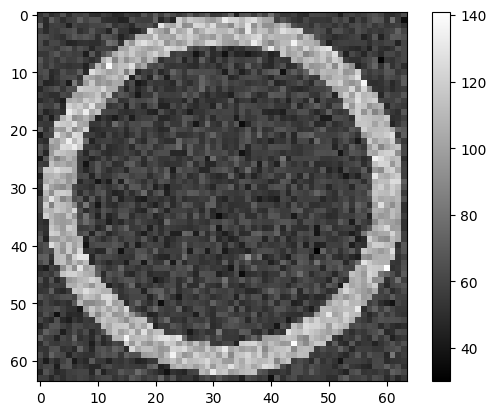

(90, 4096)
[[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 2. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


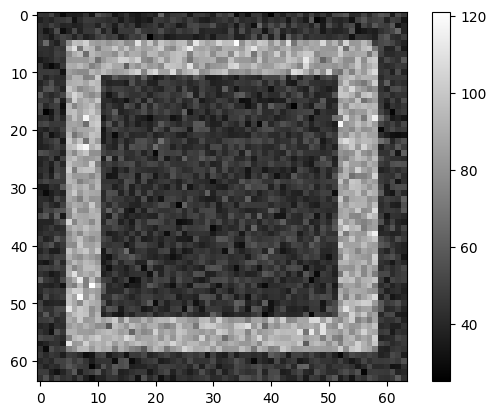

(125, 4096)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 [0. 1. 1. ... 0. 4. 0.]
 ...
 [0. 2. 0. ... 2. 2. 0.]
 [0. 2. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 0.]]


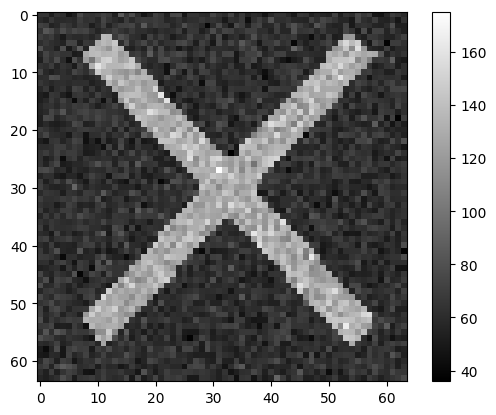

(75, 4096)
[[0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 3. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]]


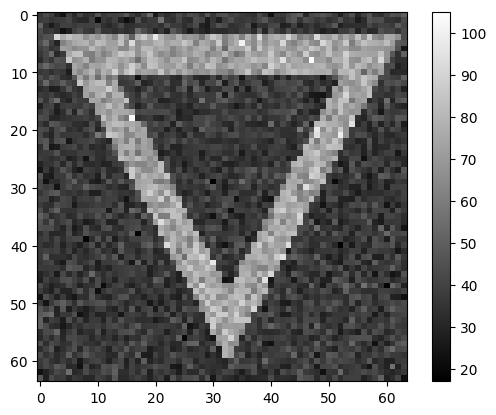

(105, 4096)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 1. 1.]
 ...
 [1. 0. 1. ... 2. 1. 0.]
 [0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


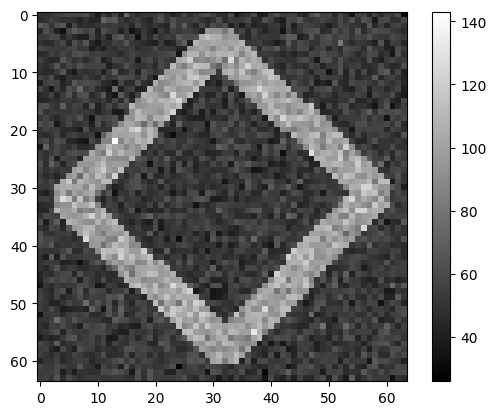

(105, 4096)
[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 2. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


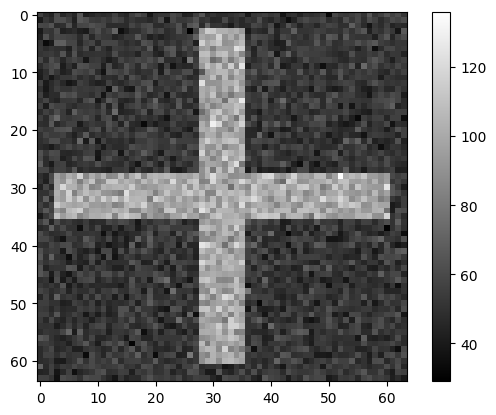

In [ ]:
# stim = 0
for stim in range(6):
  time_of_stimulus_bins = [[value - 30 for value in row] for row in stimulus_time_bins_list]
  specific_stim_data = data_stim[time_of_stimulus_bins[stim]]
  print(specific_stim_data.shape)
  print(specific_stim_data)
  
  spk_sum_stim = np.sum(specific_stim_data, axis=0)
  activity_image = spk_sum_stim.reshape((64,64))
  
  plt.imshow(activity_image, cmap='gray')
  plt.colorbar()
  plt.show()
